In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from steves_utils.utils_v2 import get_datasets_base_path

In [2]:
# 34 seconds to process 1e6 samples
class Packet_Detector:
    def __init__(
        self,
        symbol_length:int
    ):
        self.symbol_length = symbol_length
        
        self.R   = np.empty(0, dtype=np.complex128)
        self.R_d = np.empty(0, dtype=np.complex128)
        self.m = []
    def add(self, c:complex)->float:
        self.R = np.append(self.R, c)
        
        if len(self.R) > self.symbol_length:
            self.R_d = np.append(self.R_d, self.R[0])
            self.R = np.delete(self.R, 0)
            
            if len(self.R_d) > self.symbol_length:
                self.R_d = np.delete(self.R_d, 0)
            
        
        if len(self.R_d) == self.symbol_length:
            c = np.multiply(self.R, self.R_d.conjugate())
            p = np.square(np.abs(self.R_d))
            
            c = np.sum(c)
            p = np.sum(p)
            
            top = np.square(np.abs(c))
            bottom = np.square(p)
            
            self.m.append(np.divide(top, bottom))
    def get_m(self):
        return self.m
    
    def get_packet_indices(self, up_threshold=0.8, down_threshold=0.3, min_duration=16):
        indices = []
        i = 0
        in_packet = False
        duration = 0
        plateau_start = 0
        while i < len(self.m):
            if self.m[i] > up_threshold and not in_packet:
                plateau_start = i
                in_packet = True
                
            if in_packet:
                duration += 1
            
            if duration == min_duration and in_packet:
                indices.append(plateau_start)
                
            if self.m[i] < down_threshold:
                in_packet = False
                duration = 0
            i += 1
        return indices

# 9 seconds on 1e6 samples
def get_packet_indices(window_size, signal)->list:
    R = np.lib.stride_tricks.sliding_window_view(signal, window_size)[window_size:]
    R_d = np.lib.stride_tricks.sliding_window_view(signal[:-window_size], window_size)


    C = []
    for r, r_d in zip(R, R_d):
        s = np.multiply(r, np.conjugate(r_d))
        s = np.sum(s)

        C.append(s)

    C = np.array(C)
    
    P = []
    for r_d in R_d:
        p = np.square(np.abs(r_d))
        p = np.sum(p)
        P.append(p)
    P = np.array(P)
    
    top = np.square(np.abs(C))
    bottom = np.square(P)

    M = np.divide(top, bottom)
    
    pd = Packet_Detector(16)
    pd.m = M
    
    return pd.get_packet_indices()

In [3]:
bin_path = os.path.join(get_datasets_base_path(), "KRI-16Devices-RawData/14ft/WiFi_air_X310_3123D52_14ft_run1.sigmf-data")
bin_path = os.path.join(get_datasets_base_path(), "KRI-16Devices-RawData/38ft/WiFi_air_X310_3123D52_38ft_run1.sigmf-data")
bin_path = os.path.join(get_datasets_base_path(), "KRI-16Devices-RawData/50ft/WiFi_air_X310_3123D52_50ft_run1.sigmf-data")
# bin_path = os.path.join(get_datasets_base_path(), "KRI-16Devices-RawData/20ft/WiFi_air_X310_3123D52_20ft_run1.sigmf-data")
with open(bin_path, "r+") as f:
    all_x = np.memmap(f, np.complex128)

In [4]:
header_indices_path = "/mnt/wd500GB/CSC500/csc500-main/csc500-dataset-preprocessor/ORACLE_framed/isolate_headers/indices.json"

with open(header_indices_path, "r") as f:
    header_indices = json.load(f)

for naked_path in list(header_indices.keys()):
    full_path = os.path.join(get_datasets_base_path(), naked_path)
    header_indices[full_path] = header_indices[naked_path]
    del header_indices[naked_path]


matlab_indices = header_indices[bin_path]

In [5]:
# pd = Packet_Detector(symbol_length=16)
# for c in all_x[:1000000]:
#     pd.add(c)

# my_indices=pd.get_packet_indices()
my_indices = get_packet_indices(16, all_x)

First matlab packet start: 1628


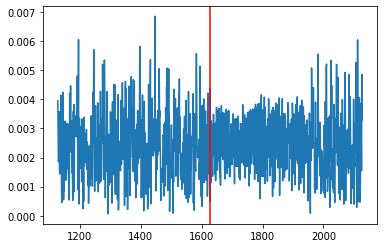

In [7]:
# Hey matlab looks like its doing a good job here
idx_to_get = 0
print("First matlab packet start:", matlab_indices[idx_to_get])
start = matlab_indices[idx_to_get]-500
stop = matlab_indices[idx_to_get]+500
r = [i + start for i in range(stop-start)]



plt.plot(r, np.abs(all_x[start:stop]))
plt.axvline(x=matlab_indices[idx_to_get], color='red')
plt.show()

In [11]:
# We allow a difference in index up to 5 samples
# The vast majority are off my one, I accounted for matlab being 1-indexed so I'm not sure where
# this offset of 1 is coming from.
if len(matlab_indices) != len(my_indices):
    raise Exception("Index lengths differ")

for mine, matlabs in zip(my_indices, matlab_indices):
    if np.abs(mine-matlabs) > 5:
        raise Exception(f"{mine}, {matlabs}")
print("It works!")

It works!
